<a href="https://colab.research.google.com/github/cinmon/endo-detection/blob/main/FINAL_%5B%EC%98%81%EC%83%81%EC%9D%B4%ED%95%B4%5D_Endometriosys_Detection(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Endometryosis Detection

In [2]:
import matplotlib.pyplot as plt
# from google.colab import filesIn
import os, shutil, random
from sklearn.model_selection import train_test_split

This project is utilizing the [GLENDA dataset](https://ftp.itec.aau.at/datasets/GLENDA/).

In particular, it is using:
- 373 pathology-present classes (including annotations).
- 13 438 frames of no pathology.  

In [3]:
!wget -O annotated_classes.zip https://ftp.itec.aau.at/datasets/GLENDA/downloads//Glenda_v1.5_classes.zip
!wget -O no_pathology.zip https://ftp.itec.aau.at/datasets/GLENDA/downloads/GLENDA_v1.5_no_pathology.zip

--2025-06-23 23:48:47--  https://ftp.itec.aau.at/datasets/GLENDA/downloads//Glenda_v1.5_classes.zip
Resolving ftp.itec.aau.at (ftp.itec.aau.at)... 143.205.173.53
Connecting to ftp.itec.aau.at (ftp.itec.aau.at)|143.205.173.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28009709 (27M) [application/zip]
Saving to: ‘annotated_classes.zip’

annotated_classes.z 100%[===================>]  26.71M  8.87MB/s    in 3.0s    

2025-06-23 23:48:51 (8.87 MB/s) - ‘annotated_classes.zip’ saved [28009709/28009709]

--2025-06-23 23:48:51--  https://ftp.itec.aau.at/datasets/GLENDA/downloads/GLENDA_v1.5_no_pathology.zip
Resolving ftp.itec.aau.at (ftp.itec.aau.at)... 143.205.173.53
Connecting to ftp.itec.aau.at (ftp.itec.aau.at)|143.205.173.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 867544435 (827M) [application/zip]
Saving to: ‘no_pathology.zip’

no_pathology.zip    100%[===================>] 827.35M  7.23MB/s    in 98s     

2025-06-23 23:50

In [4]:
!unzip annotated_classes.zip
!unzip no_pathology.zip

Streaming output truncated to the last 5000 lines.
  inflating: no_pathology/frames/v_4044_s_0-253/f_27.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_28.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_29.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_3.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_30.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_31.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_32.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_33.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_34.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_35.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_36.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_37.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_38.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_39.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_4.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_40.jpg  
  infla

## Classification

After trying many class imbalance handling methods, I have come to the conclusion that I must undersample the negative cases and oversample the positive ones (for training only).

In [5]:
import numpy as np

# 2) Re-organize into train/validation folders for ImageDataGenerator

# original paths
pos_dir = 'Glenda_v1.5_classes/frames'
neg_dir = 'no_pathology/frames'

# new base
base_dir = 'data'
for split in ['train','validation']:
    for cls in ['positive','negative']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# collect all filepaths
pos_files = [os.path.join(dp, f) for dp,_,fs in os.walk(pos_dir) for f in fs if f.lower().endswith(('.jpg','.png'))]
neg_files = [os.path.join(dp, f) for dp,_,fs in os.walk(neg_dir) for f in fs if f.lower().endswith(('.jpg','.png'))]

# train/val split
pos_tr, pos_val = train_test_split(pos_files, test_size=0.2, random_state=42)

# Sample only a subset of negative training files
neg_tr_full, neg_val = train_test_split(neg_files, test_size=0.2, random_state=42)

# UNDERSAMPLING: keep only N_neg_train negatives (e.g., 3x positives)
desired_ratio = 2  # e.g., 3 negatives per positive
n_pos_train = len(pos_files) * 0.8  # approx 80% of 373
n_neg_train = int(desired_ratio * n_pos_train)
neg_tr = np.random.choice(neg_tr_full, size=n_neg_train, replace=False).tolist()

print(f"Positive train files: {len(pos_tr)}")
print(f"Positive validation files: {len(pos_val)}")
print(f"Negative train files: {len(neg_tr)}")
print(f"Negative validation files: {len(neg_val)}")

Positive train files: 298
Positive validation files: 75
Negative train files: 596
Negative validation files: 2688


In [6]:
# copy
for src_list, split, label in [
    (pos_tr, 'train','positive'),
    (pos_val,'validation','positive'),
    (neg_tr, 'train','negative'),
    (neg_val,'validation','negative'),
]:
    for src in src_list:
        # avoid overwriting
        unique_prefix = os.path.basename(os.path.dirname(src))
        new_name = f"{unique_prefix}_{os.path.basename(src)}"
        dst = os.path.join(base_dir, split, label, new_name)
        shutil.copy2(src, dst)

num_pos_files = sum([len(files) for r, d, files in os.walk('/content/data/train/positive')]) + sum([len(files) for r, d, files in os.walk('/content/data/validation/positive')])
num_neg_files = sum([len(files) for r, d, files in os.walk('/content/data/train/negative')]) + sum([len(files) for r, d, files in os.walk('/content/data/validation/negative')])

print(f"Number of files in /content/data/train/positive + /content/data/validation/positive: {num_pos_files}")
print(f"Number of files in /content/data/train/negative + /content/data/validation/negative: {num_neg_files}")

Number of files in /content/data/train/positive + /content/data/validation/positive: 373
Number of files in /content/data/train/negative + /content/data/validation/negative: 3284


In [7]:
# 3) Classification pipeline with transfer learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
img_size = (224,224)
batch_size = 32

# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=False,
    validation_split=0.0  # we'll use separate dirs
)
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)
val_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir,'validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 894 images belonging to 2 classes.
Found 2763 images belonging to 2 classes.


In [9]:
# Focal Loss

import tensorflow as tf
from tensorflow.keras import backend as K

def binary_focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        modulating_factor = tf.pow(1. - p_t, gamma)

        return tf.reduce_mean(-alpha_factor * modulating_factor * tf.math.log(p_t + epsilon))
    return loss

In [26]:
# build model
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*img_size,3))
base.trainable = False
clf = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
clf.compile(
    optimizer='adam',
    loss=binary_focal_loss(),
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)
# callbacks
callbacks = [
    ModelCheckpoint('best_classifier.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

In [27]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))

In [12]:
# train
clf_history = clf.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.6575 - loss: 0.0864

28/28 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6574 - loss: 0.0861 - val_accuracy: 0.9729 - val_loss: 0.0474
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6575 - loss: 0.0674

28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6578 - loss: 0.0673 - val_accuracy: 0.9729 - val_loss: 0.0337
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6797 - loss: 0.0627

28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6793 - loss: 0.0628 - val_accuracy: 0.9729 - val_loss: 0.0280
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6790 - loss: 0.0632 - val_accuracy: 0.9729 - val_loss: 0.0596
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6449 - loss: 0.0691 - val_accuracy: 0.9729 - val_loss: 0.0304
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6766 - loss: 0.0638 - val_accuracy: 0.9729 - val_loss: 0.0449
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6641 - loss: 0.0661 - val_accuracy: 0.9729 - val_loss: 0.0411
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6632 - loss: 0.0669 - val_accuracy: 0.9729 - val_loss: 0.0441


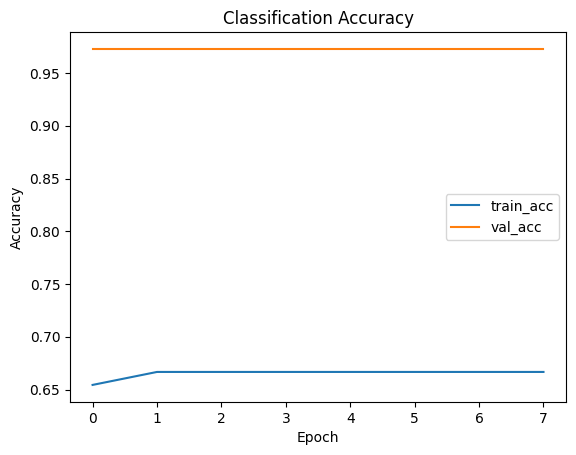

In [13]:
plt.figure()
plt.plot(clf_history.history['accuracy'], label='train_acc')
plt.plot(clf_history.history['val_accuracy'], label='val_acc')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Same thing, either:
- Validation is so easy that triaining is having a harder time due to data augmentation.
- The training examples are suffering from heavy augmentations (rotations, flips, etc.) that the network still hasn’t mastered.

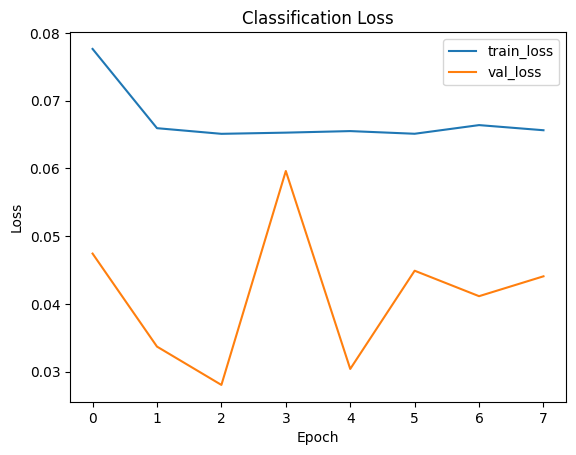

In [14]:
plt.figure()
plt.plot(clf_history.history['loss'], label='train_loss')
plt.plot(clf_history.history['val_loss'], label='val_loss')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

87/87 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step


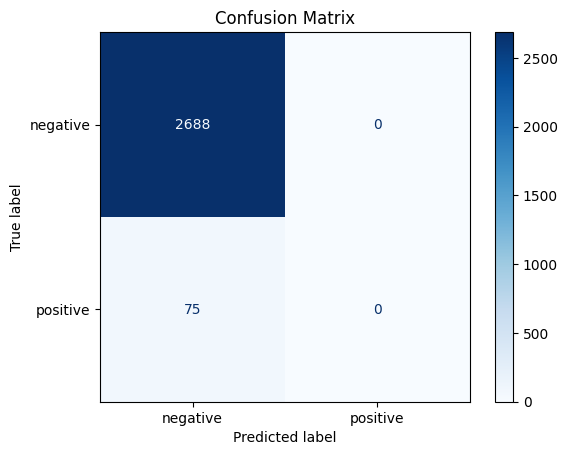

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay

# 1) Gather true labels & predicted probabilities
y_true = val_gen.classes                      # integer labels
y_prob = clf.predict(val_gen).ravel()
y_pred = (y_prob > 0.5).astype(int)

# 2) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

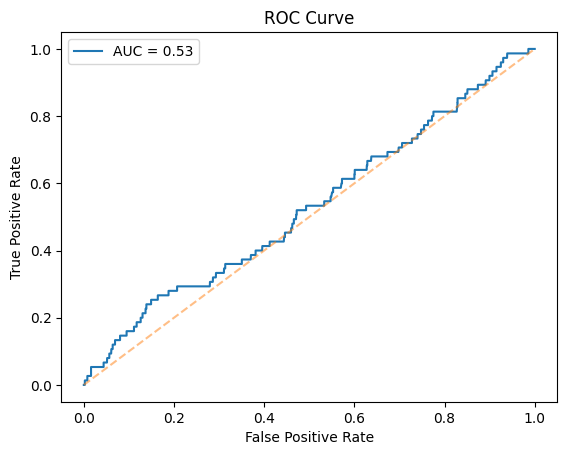

In [16]:
# 3) ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

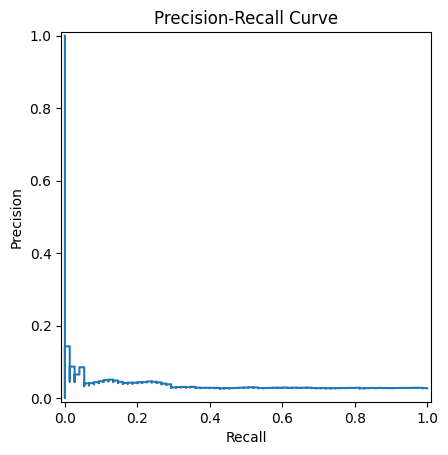

In [17]:
# 4) Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_display = PrecisionRecallDisplay(precision=prec, recall=rec)
pr_display.plot()
plt.title("Precision-Recall Curve")
plt.show()

## Segmentation

In [18]:
# 4) U-Net segmentation pipeline
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# paths
img_paths  = sorted(glob.glob('Glenda_v1.5_classes/frames/**/*.jpg',  recursive=True))
mask_paths = sorted(glob.glob('Glenda_v1.5_classes/annots/**/*.png',  recursive=True))

# split
imgs_tr, imgs_val, msks_tr, msks_val = train_test_split(
    img_paths, mask_paths, test_size=0.2, random_state=42)

In [19]:
# helper funcs
def preprocess(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size) / 255.0
    m   = tf.io.read_file(mask_path)
    m   = tf.image.decode_png(m, channels=1)
    m   = tf.image.resize(m, img_size) / 255.0
    return img, m

train_ds = tf.data.Dataset.from_tensor_slices((imgs_tr, msks_tr)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(16).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((imgs_val, msks_val)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(16).prefetch(tf.data.AUTOTUNE)

In [20]:
# dice loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    inter  = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [21]:
# U-Net model
inputs = Input((*img_size,3))
c1 = Conv2D(64,3,activation='relu',padding='same')(inputs)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(128,3,activation='relu',padding='same')(p1)
p2 = MaxPooling2D()(c2)

c3 = Conv2D(256,3,activation='relu',padding='same')(p2)

u2 = Conv2DTranspose(128,3,strides=2,padding='same')(c3)
u2 = concatenate([u2,c2])
c4 = Conv2D(128,3,activation='relu',padding='same')(u2)

u1 = Conv2DTranspose(64,3,strides=2,padding='same')(c4)
u1 = concatenate([u1,c1])
c5 = Conv2D(64,3,activation='relu',padding='same')(u1)

outputs = Conv2D(1,1,activation='sigmoid')(c5)
unet = Model(inputs, outputs)

unet.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

# segmentation callbacks & train
seg_callbacks = [
    ModelCheckpoint('best_unet.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]


In [22]:
seg_history = unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=seg_callbacks
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0713 - loss: 0.9287   

19/19 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - dice_coef: 0.0711 - loss: 0.9288 - val_dice_coef: 0.0709 - val_loss: 0.9294
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - dice_coef: 0.0759 - loss: 0.9240

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - dice_coef: 0.0759 - loss: 0.9240 - val_dice_coef: 0.0961 - val_loss: 0.9014
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - dice_coef: 0.0911 - loss: 0.9089 - val_dice_coef: 0.0905 - val_loss: 0.9093
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - dice_coef: 0.1018 - loss: 0.8982

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - dice_coef: 0.1017 - loss: 0.8983 - val_dice_coef: 0.1068 - val_loss: 0.8913
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - dice_coef: 0.0458 - loss: 0.9542 - val_dice_coef: 0.0060 - val_loss: 0.9936
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - dice_coef: 0.0691 - loss: 0.9308 - val_dice_coef: 0.0679 - val_loss: 0.9325
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - dice_coef: 0.0711 - loss: 0.9289 - val_dice_coef: 0.0679 - val_loss: 0.9325
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - dice_coef: 0.0710 - loss: 0.9289 - val_dice_coef: 0.0679 - val_loss: 0.9325
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - dice_coef: 0.0711 - loss: 0.9289 - val_dice_coef: 0.0679 - val_loss: 0.9325


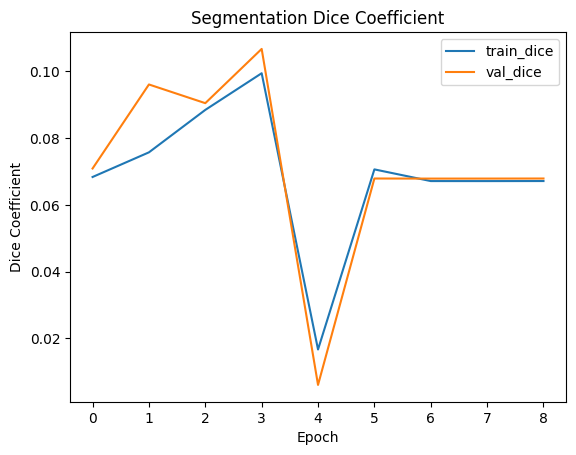

In [23]:
plt.figure()
plt.plot(seg_history.history['dice_coef'], label='train_dice')
plt.plot(seg_history.history['val_dice_coef'], label='val_dice')
plt.title('Segmentation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

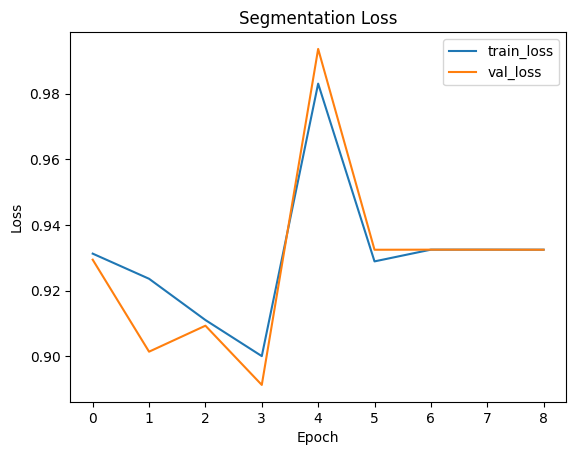

In [24]:
plt.figure()
plt.plot(seg_history.history['loss'], label='train_loss')
plt.plot(seg_history.history['val_loss'], label='val_loss')
plt.title('Segmentation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


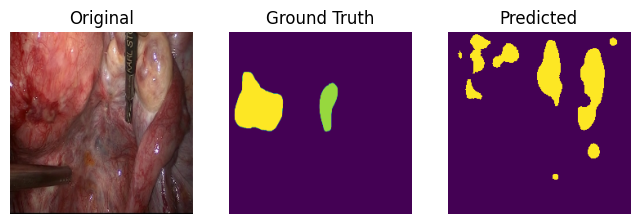

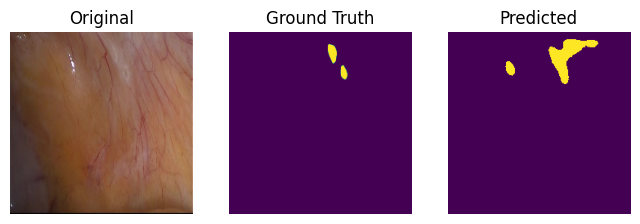

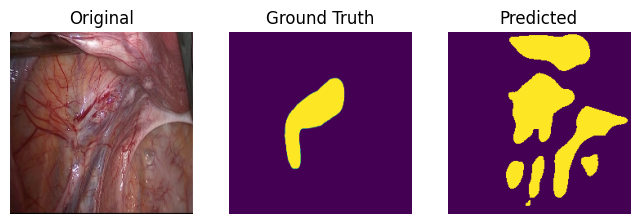

In [25]:
# --- Sample segmentation results ---
num_samples = 3
for images, masks in val_ds.take(1):
    preds = unet.predict(images)
    for i in range(num_samples):
        plt.figure(figsize=(8,4))
        # Original image
        plt.subplot(1,3,1)
        plt.imshow(images[i])
        plt.title('Original')
        plt.axis('off')
        # Ground truth mask
        plt.subplot(1,3,2)
        plt.imshow(masks[i].numpy().squeeze())
        plt.title('Ground Truth')
        plt.axis('off')
        # Predicted mask
        plt.subplot(1,3,3)
        plt.imshow(preds[i].squeeze() > 0.5)
        plt.title('Predicted')
        plt.axis('off')
        plt.show()